<a href="https://colab.research.google.com/github/castudil/Machine-Learning/blob/main/Proyecto%20Final%20ML/%20Entrega%2005%20-%20Interpret/%20Entrega_05_Interpret_wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El siguiente notebook muestra el ciclo completo del método OSEMN. Éste método involucra la obtención, limpieza, exploración, modelamiento, e interpretación de los datos. 

En esta ocasión se procesan datos correspondientes a evaluaciones de vinos.

###PASO 1: OBTAIN


In [34]:
# Imports
# Data import and manipulation
import pandas as pd

# Math
import numpy as np
# Seeding the whole notebook (although in general I also always set my random
# state manually when it is an option)
np.random.seed(543)

# Some statistics, including some checks for normality and skew
from scipy import stats
from scipy.stats import norm, skew
from scipy.stats import kurtosis, skew

# Create a train-test split, so we reserve some data for testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
# Prettier visualizations
import seaborn as sns
# Sets the default style for seaborn, adding the nice darkgrid background
sns.set()
from wordcloud import WordCloud, STOPWORDS 


 almacenamos en una variable la dirección URL donde se encuentran los datos.

In [33]:
URL = "https://raw.githubusercontent.com/castudil/Machine-Learning/main/Proyecto%20Final%20ML/%20Entrega%2005%20-%20Interpret/winemag-data-130k-v2.csv"


In [35]:
df = pd.read_csv(URL, index_col=0)
df.head()


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Los datos son de naturaleza diversa incluyendo códigos de países, texto que describen al vino, designación, puntaje, lugar de origen, etc.

### PASO 2: SCRUB

In [36]:
df.describe()

,points,price
count,65499.000000,60829.000000
mean,88.434037,35.232932
std,3.030310,39.477858
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,2500.000000


oslo nos muestra detalles estadísticos de las variables numéricas, en este caso son sólo dos columnas, ya que las otras son categóricas



In [37]:
#Comprobando las dimensiones
df.shape

(65499, 13)

En total hay 13 columnas de naturaleza diversa y ~65K filas.

In [38]:
#comprobando si hay alguna inconsistencia en el tipo de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65499 entries, 0 to 65498
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                65467 non-null  object 
 1   description            65499 non-null  object 
 2   designation            46588 non-null  object 
 3   points                 65499 non-null  int64  
 4   price                  60829 non-null  float64
 5   province               65467 non-null  object 
 6   region_1               54744 non-null  object 
 7   region_2               25170 non-null  object 
 8   taster_name            51856 non-null  object 
 9   taster_twitter_handle  49467 non-null  object 
 10  title                  65499 non-null  object 
 11  variety                65499 non-null  object 
 12  winery                 65499 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 7.0+ MB


In [39]:

# función para investigar los valores faltantes en el conjunto de datos de vino
def MissingValues(df): #creating the function
    total = df.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (df.isnull().sum() / df.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print(df[~(df['Total'] == 0)])# Returning values of nulls different of 0
    
    return

MissingValues(df)


                       Total    Percent
region_2               40329  61.571932
designation            18911  28.872197
taster_twitter_handle  16032  24.476710
taster_name            13643  20.829326
region_1               10755  16.420098
price                   4670   7.129880
country                   32   0.048856
province                  32   0.048856


Se muestran exclusivamente aquellas columnas que contienen datos faltantes. En este caso hay siete columnas que contienen datos faltantes.

In [40]:
#Lista completa de funciones, con o sin datos faltantes
df.isna().sum()


country                     32
description                  0
designation              18911
points                       0
price                     4670
province                    32
region_1                 10755
region_2                 40329
taster_name              13643
taster_twitter_handle    16032
title                        0
variety                      0
winery                       0
dtype: int64

Aquí se hace una lista completa de las columnas incluyendo aquellas que no contienen datos faltantes.

In [41]:
#Reduzca los datos a mis dos características de interés y la variable de destino, datos limpios
winedf = df[['points', 'price', 'description']].copy()
winedf = df.dropna().reset_index(drop=True)

En este caso sólo vamos a considerar tres columnas del conjunto de datos: el puntaje, precio y la descripción.

Simplemente se eliminaron aquellas instancias que contienen datos faltantes

Se creó un nuevo data frame para almacenar estos datos filtrados y limpios.

In [42]:
len(winedf)

11020

El conjunto de datos se redujo a 11.000 instancias

In [ ]:
# Compruebo si hay duplicados, lo que a menudo es valioso, pero en este caso reduce el conjunto de datos en un factor de 5
# Esto elimina demasiados valores, volverá si hay tiempo
# df = df[df.duplicated('description', keep=False)]

# len(winedf) después de duplicado eliminado = 20026, no vale la pena realizar esta operación

###EXPLORE

La etapa de exploración a veces se conoce con el nombre de análisis exploratorio de datos (EDA).

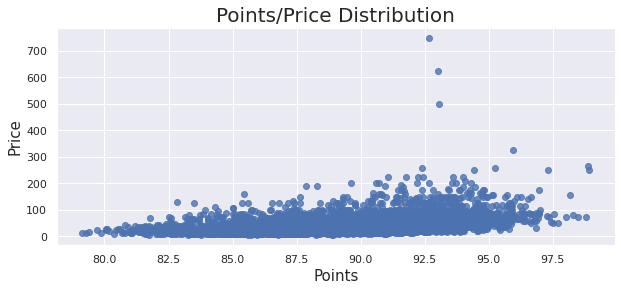

In [43]:
#Algunos valores atípicos a tener en cuenta
plt.figure(figsize=(10,4))

g = sns.regplot(x='points', y='price', data=winedf, x_jitter=True, fit_reg=False)
g.set_title("Points/Price Distribution", fontsize=20)
g.set_xlabel("Points", fontsize= 15)
g.set_ylabel("Price", fontsize= 15)

plt.show()

No se percibe un patrón claro al realizar un gráfico de dispersión entre el puntaje y el precio del vino

In [44]:
#Crea una nueva columna que se usará en el modelado
#obteniendo el recuento de palabras de cada descripción de vino como una variable
winedf2 = winedf.assign(desc_length = winedf['description'].apply(len))
winedf2.head()


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,desc_length
0,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,249
1,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,243
2,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi,251
3,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa,259
4,US,As with many of the Erath 2010 vineyard design...,Hyland,86,50.0,Oregon,McMinnville,Willamette Valley,Paul Gregutt,@paulgwine,Erath 2010 Hyland Pinot Noir (McMinnville),Pinot Noir,Erath,242


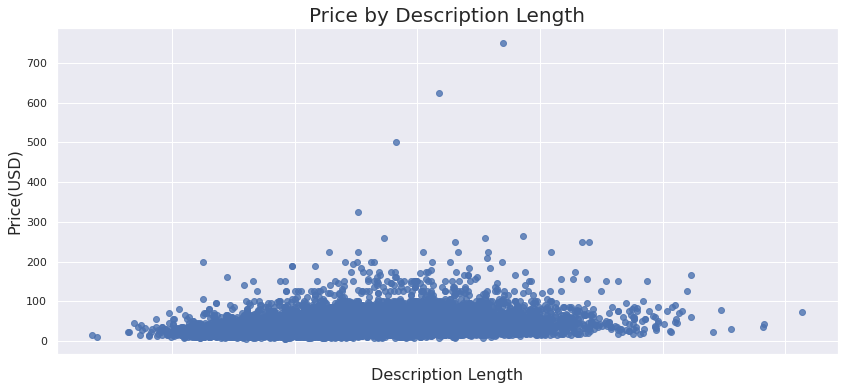

In [45]:
# Comparar Descripción Longitud con Precio
plt.figure(figsize=(14,6))
g = sns.regplot(x='desc_length', y='price', data=winedf2, fit_reg=False)
g.set_title('Price by Description Length', fontsize=20)
g.set_ylabel('Price(USD)', fontsize = 16) 
g.set_xlabel('Description Length', fontsize = 16)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
plt.show()

A partir del gráfico de dispersión, es difícil argumentar que existe un patrón que vincule el largo de palabras en la descripción con el precio del vino

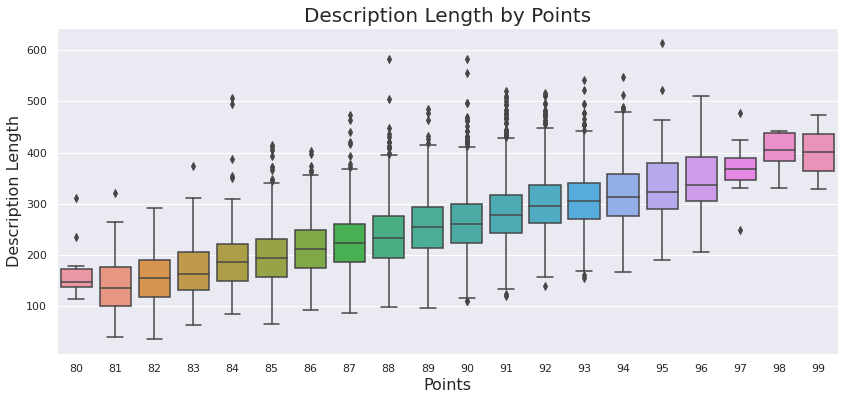

In [ ]:
#Esto presagia que la clasificación puede no ser el mejor modelo aquí.
#Una regresión lineal probablemente sería un modelo más preciso,
#pero sometámoslo a una prueba de clasificación para estar seguros
plt.figure(figsize=(14,6))
g = sns.boxplot(x='points', y='desc_length', data=winedf2)
g.set_title('Description Length by Points', fontsize=20)
g.set_ylabel('Description Length', fontsize = 16) # Y label
g.set_xlabel('Points', fontsize = 16) # X label
plt.show()


En otro intento, construimos gráficos de caja que vinculen el puntaje del vino con el largo de la descripción. Aquí aparece un patrón lineal que podríamos interpretar de la siguiente manera: existe una relación lineal entre el puntaje del vino y el largo de la decripción en términos de la media.

Vemos algunas diferencias en el patrón en los extremos, esto es cuando el puntaje es demasiado alto o demasiado bajo. Una alternativa sería truncar esta situación en esos datos extremos y analizarlos de manera independiente

Text(0, 0.5, 'Count')

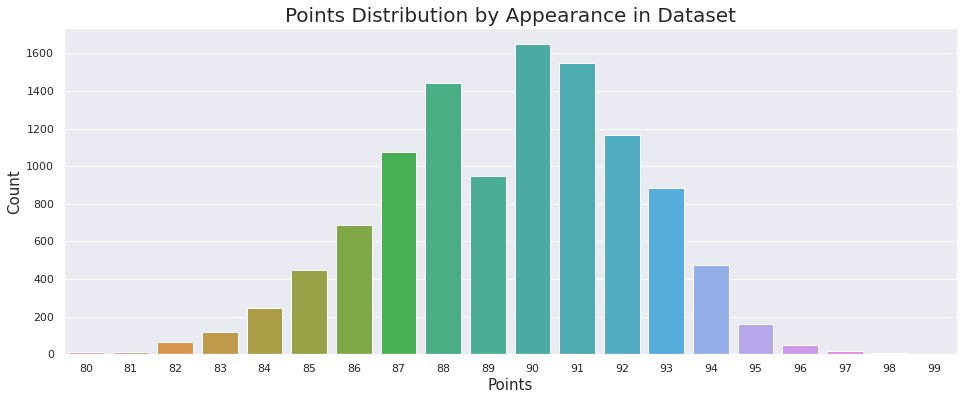

In [ ]:
#grafico de barras para visualizar cómo se distribuyen los puntos visualmente, para tener una mejor idea de cómo agruparlos al simplificar
plt.figure(figsize=(16,6))
g = sns.countplot(x='points', data=winedf)
g.set_title("Points Distribution by Appearance in Dataset", fontsize=20) 
g.set_xlabel("Points", fontsize=15) 
g.set_ylabel("Count", fontsize=15)


la distribucion es muy parecida a una Gaussiana. Es posible que se usa un histograma con un bin un poco más ancho se podrá ver la distribución Gaussiana con mucha más claridad. En promedio los puntajes de los Pinos se concentran entre los 88 y 90 puntos. También observamos que hay una leve baja exactamente cuando existen 89 puntos. el impacto de tener una distribucion normal es que podríamos generar un modelo paramétrico. Esto quiere decir que podríamos usar una función analítica y estimar el valor de la media y la desviación estándar para modelar este fenómeno.

In [46]:
#Trabajar con tantos puntos y precios puede dificultar el modelado. voy a demostrar esto
#con mi primera entrada en la siguiente sección, pero por ahora crearé algunas funciones que me ayuden
#restringir los puntos y precios

#Método tomando puntos como parámetro y simplificándolos en 5 categorías
def points_simplified(points):
    if points < 84:
        return 1
    elif points >= 84 and points < 88:
        return 2 
    elif points >= 88 and points < 92:
        return 3 
    elif points >= 92 and points < 96:
        return 4 
    else:
        return 5

#Método tomando el precio como parámetro, haciendo una división binaria en 100, ya que este es un importante
#umbral en la industria del vino en precio versus calidad
def price_simplified(price):
    if price < 100:
        return 0
    else:
        return 1
    
#Aplicando el método de transformación y asignando el resultado a la nueva columna "points_simplified"
winedf2 = winedf2.assign(points_simplified = winedf2['points'].apply(points_simplified))
#Aplicar otro método de transformación, asignando el resultado a la nueva columna "price_simplified"
winedf2 = winedf2.assign(price_simplified = winedf2['price'].apply(price_simplified))


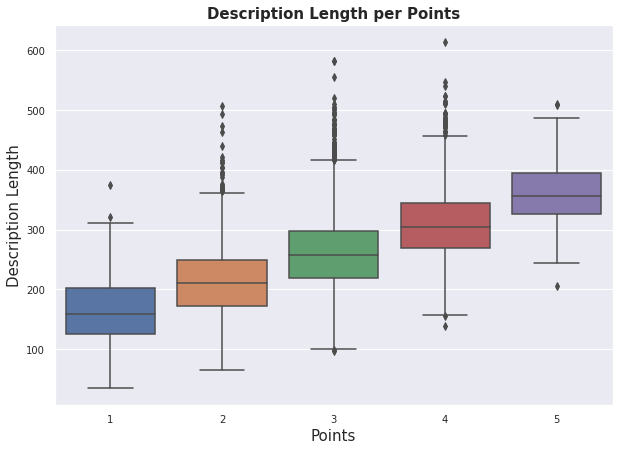

In [50]:
#Visualiza nuestras dos variables recién transformadas

#Primero, la longitud de la descripción y los puntos agrupados en 5 categorías
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='points_simplified', y='desc_length', data=winedf2)
plt.xticks(fontsize=10) # X Ticks
plt.yticks(fontsize=10) # Y Ticks
ax.set_title('Description Length per Points', fontweight="bold", size=15) 
ax.set_ylabel('Description Length', fontsize = 15)
ax.set_xlabel('Points', fontsize = 15) 
plt.show()


En este caso aparece un patrón clarísimo en el gráfico de caja. Es posible apreciar una tendencia lineal en las medias de los gráficos de caja al discretizar puntaje del vino en cinco categorías distintas

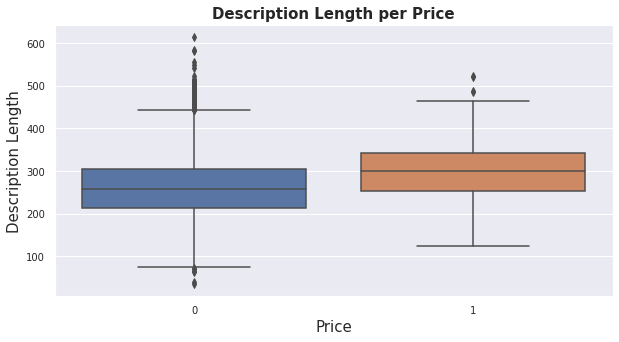

In [51]:
#Entonces, el precio binario
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='price_simplified', y='desc_length', data=winedf2)
plt.xticks(fontsize=10) # X Ticks
plt.yticks(fontsize=10) # Y Ticks
ax.set_title('Description Length per Price', fontweight="bold", size=15) 
ax.set_ylabel('Description Length', fontsize = 15)
ax.set_xlabel('Price', fontsize = 15) 
plt.show()

###MODEL

Points/Description Length

In [52]:
#Primero, pruebo el modelo Random Forest Classifier sin ningún tipo de escalado simplemente para demostrar
#la necesidad tanto de escalar como de crear las simplificaciones que hice en mi sección EDA anterior

from sklearn.ensemble import RandomForestClassifier

# Entrenando al modelo
X = winedf2.iloc[:,-1:] # This is the last column I created above, desc_length for description length
y = winedf2['points']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

# Testing the model
predictions = rfc.predict(np.array(X_test).reshape(-1,1))
# Very imprecise.
print(classification_report(y_test, predictions))
#Very inaccurate
print('Overall Accuracy: ', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

          80       0.00      0.00      0.00         4
          81       0.00      0.00      0.00         3
          82       0.00      0.00      0.00        14
          83       0.00      0.00      0.00        29
          84       0.00      0.00      0.00        52
          85       0.00      0.00      0.00       110
          86       0.00      0.00      0.00       173
          87       0.00      0.00      0.00       281
          88       0.00      0.00      0.00       373
          89       0.00      0.00      0.00       240
          90       0.15      0.99      0.26       406
          91       0.00      0.00      0.00       389
          92       0.00      0.00      0.00       291
          93       0.23      0.08      0.12       221
          94       0.00      0.00      0.00       117
          95       0.00      0.00      0.00        27
          96       0.00      0.00      0.00        16
          97       0.00    

In [53]:
# Training the model
# X = desc_length 
#(our same X from before)
y = winedf2['points_simplified'] # and simplified points
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

# Testing the model
predictions = rfc.predict(np.array(X_test).reshape(-1,1))
print(classification_report(y_test, predictions))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00       616
           3       0.52      0.99      0.68      1408
           4       0.65      0.08      0.14       656
           5       0.00      0.00      0.00        25

    accuracy                           0.52      2755
   macro avg       0.23      0.21      0.16      2755
weighted avg       0.42      0.52      0.38      2755

Overall Accuracy:  0.523049001814882


In [54]:
from sklearn.preprocessing import MinMaxScaler

#Escalar la longitud de la descripción del vino
scaler=MinMaxScaler()
scaled_wine=scaler.fit_transform(winedf2[['desc_length']])
foo=pd.DataFrame(scaled_wine)
X=foo[0]
y=winedf2.points_simplified

In [55]:
#Scaling the wine description length gives a negligible performance boost
scaler=MinMaxScaler()
scaled_wine=scaler.fit_transform(winedf2[['desc_length']])
newdf=pd.DataFrame(scaled_wine)
X=newdf[0]
y=winedf2.points_simplified

# Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

# Testing the model
predictions = rfc.predict(np.array(X_test).reshape(-1,1))
print(classification_report(y_test, predictions))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))


              precision    recall  f1-score   support

           1       0.31      0.10      0.15        50
           2       0.46      0.26      0.33       616
           3       0.55      0.76      0.64      1408
           4       0.48      0.31      0.38       656
           5       0.00      0.00      0.00        25

    accuracy                           0.52      2755
   macro avg       0.36      0.29      0.30      2755
weighted avg       0.50      0.52      0.49      2755

Overall Accuracy:  0.523049001814882


Price/Description Length

In [56]:
#Mientras prediga vinos por debajo de $100, este es un clasificador excelente
X = winedf2.desc_length
y = winedf2.price_simplified
# Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

# Testing the model
predictions = rfc.predict(np.array(X_test).reshape(-1,1))
print(classification_report(np.array(y_test).reshape(-1,1), predictions))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))


              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2677
           1       0.00      0.00      0.00        78

    accuracy                           0.97      2755
   macro avg       0.49      0.50      0.49      2755
weighted avg       0.94      0.97      0.96      2755

Overall Accuracy:  0.9709618874773139


In [57]:
#Uso el escalado MinMax en mi análisis aquí, pero el escalado Estándar ofrece resultados comparables
#aunque con un poco menos de exactitud/precisión en el entrenamiento/pruebas realizadas fuera de este portátil
scaler=MinMaxScaler()
scaled_wine=scaler.fit_transform(winedf2[['desc_length']])
newdf=pd.DataFrame(scaled_wine)
X=newdf[0]
y=winedf2.price_simplified
# Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

# Testing the model
predictions = rfc.predict(np.array(X_test).reshape(-1,1))
print(classification_report(np.array(y_test).reshape(-1,1), predictions))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))


              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2677
           1       0.00      0.00      0.00        78

    accuracy                           0.97      2755
   macro avg       0.49      0.50      0.49      2755
weighted avg       0.94      0.97      0.96      2755

Overall Accuracy:  0.9716878402903811


In [58]:
#Tratando de excluir algunos de los valores atípicos superiores extremos para el precio
#Esto hace que el modelo sea mucho menos preciso. Reflexionaré sobre las posibles razones en la siguiente sección.
y = winedf2[winedf2['price'] <= 500]['price']
X = winedf2[winedf2['price'] <= 500]['desc_length']
# Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

# Testing the model
predictions = rfc.predict(np.array(X_test).reshape(-1,1))
print('Overall Accuracy: ', accuracy_score(y_test, predictions))

Overall Accuracy:  0.038112522686025406


###Interpret

**Descripción Longitud para Clasificar Puntos:**


Una posible explicación para los puntos no simplificados versus el modelo de longitud de descripción podría ser que estoy usando un modelo de clasificación, Random Forest, versus Regresión lineal. Los datos siguen siendo algo lineales después de la simplificación de los puntos en 5 categorías, pero creo que la clasificación se mantiene mejor porque hay menos ruido por la presencia de menos categorías en la variable dependiente.

Dicho esto, esta mejora en el rendimiento solo llevó al modelo a un nivel de precisión y precisión solo ligeramente superior al azar. Mantendría que la regresión lineal es probablemente el camino a seguir aquí, pero esto, por supuesto, merece más pruebas para asegurarlo.


**Descripción Largo a Clasificar Precio:**

Pasando a una interpretación de mi precio como modelo de variable dependiente, lo más notable a mencionar es que el modelo es muy preciso para vinos por debajo de 
$
100

No es exacto por encima de eso, algo que traté de abordar volviendo a mi EDA y determinando dónde sería un buen límite para los valores atípicos. Elegí 
$
500 en la sección anterior como ese límite. Este no fue un refinamiento exitoso del modelo y produjo una precisión muy baja.

Esto fue algo que probé y traté de hacer funcionar fuera de este cuaderno final para el proyecto, y no encontré que eliminar los valores atípicos a otros precios produjera mejores resultados. El modelo funciona razonablemente bien, pero solo cuando se trata de todo el conjunto de datos y todavía no estoy seguro de cómo interpretarlo.

Afortunadamente, afirmé que la gran mayoría de los bebedores de vino nunca buscan gastar más de 
$
100 en una botella, o lo hacen con muy poca frecuencia. Este modelo muestra que los vinos de cierta longitud de descripción de este conjunto de datos pueden clasificarse con alta precisión y exactitud a través del algoritmo Random Forest.

**Conclusiones:**

En conjunto, sostengo que estos dos resultados deben interpretarse en el sentido de que comprar vino con una descripción más larga que aún cuesta menos de $ 100 por botella es el mejor enfoque. Dado que era el modelo más débil, la calificación por puntos solo debe usarse como una forma secundaria de clasificar cuáles son realmente los mejores vinos.